In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
from keras.utils.np_utils import to_categorical #convert to one-hot encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

/Users/gagicha/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/gagicha/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
train_file="Downloads/digit_classifier/train.csv" #42k rows, 785 columns including a label column
test_file="Downloads/digit_classifier/test.csv"
submission_file= "Downloads/digit_classifier/submission.csv"

In [4]:
#split the dtaa into trainig set and validation set to evaluate the performance of the model
raw_data=np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=",") #skip the first row as it doesnt have any numbers
# df=pd.read_csv(train_file)

In [5]:
x_train, x_val, y_train, y_val = train_test_split(raw_data[:,1:], raw_data[:,0], test_size=0.1)

In [6]:
# Each data point consists of 784 values. 
# A fully connected net just treats all these values the same, 
# but a CNN treats it as a 28x28 square. Thes two graphs explain the difference:
# It's easy to understand why a CNN can get better results.

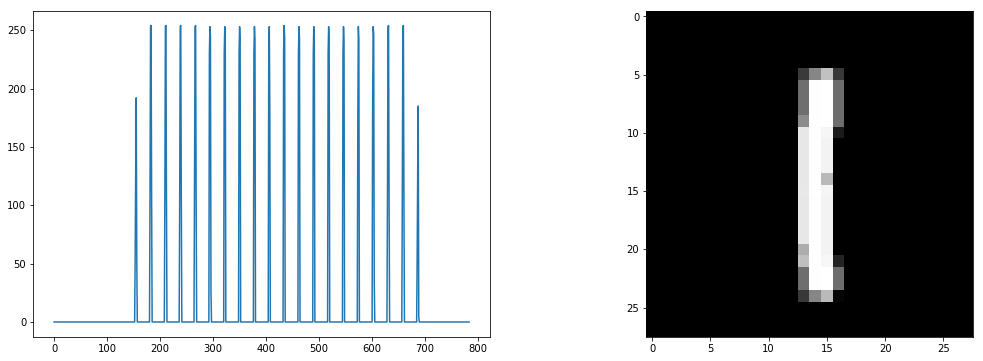

In [7]:
fig,ax= plt.subplots(1,2, figsize=(18,6))
ax[0].plot(x_train[0])
ax[1].imshow(x_train[0].reshape(28,28), cmap='gray')

In [8]:
x_train=x_train.reshape(-1, 28, 28, 1) 
x_val= x_val.reshape(-1, 28, 28, 1)
#here -1 is for unknown for the python to guess on its own 
# and so here it implies number of examples, also 1 is for #channels and in MNIST dataset images are grayscale so channels =1

In [9]:
#normalize the dataset so that its between 0 and 1, hence the convergence is faster.
x_train=x_train.astype("float32")/255
x_val=x_val.astype("float32")/255

In [10]:
#convert the labels from integers 0-9 to ones 1's and 0's using one hot encoding.
# y_train=to_categorical(y_train)
# y_val=to_categorical(y_val)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
#example:
print(y_train)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [11]:
#train the model

model= Sequential()# this just means adding one layer at a time
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)))
model.add(BatchNormalization()) #to make training faster
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization()) 
model.add(MaxPool2D(strides=(2,2))) #filter size=2, stride=2
model.add(Dropout(0.25)) #CNN is prone to overfitting due to large no of parameters, hence regularization

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2))) #filter size=2, stride=2
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))# dense layer is fully connected neural network layer
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))


In [12]:
# augmentation
datagen= ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

In [13]:
#logloss function in keras called categorical_crossentropy
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=1e-4), metrics=['accuracy'])

In [14]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
# We train once with a smaller learning rate to ensure convergence. We then speed things up, 
# only to reduce the learning rate by 10% every epoch. Keras has a function for this:

In [15]:
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=16),
                           steps_per_epoch=500,
                           epochs=20, #Increase this when not on Kaggle kernel
                           verbose=2,  #1 for ETA, 0 for silent
                           validation_data=(x_val[:400,:], y_val[:400,:]), #For speed
                           callbacks=[annealer])

Epoch 1/20
17s - loss: 0.7735 - acc: 0.7505 - val_loss: 0.6292 - val_acc: 0.8500
Epoch 2/20
17s - loss: 0.3385 - acc: 0.8939 - val_loss: 0.1609 - val_acc: 0.9475
Epoch 3/20
18s - loss: 0.2580 - acc: 0.9198 - val_loss: 0.0780 - val_acc: 0.9775
Epoch 4/20
17s - loss: 0.2046 - acc: 0.9385 - val_loss: 0.0840 - val_acc: 0.9675
Epoch 5/20
18s - loss: 0.1608 - acc: 0.9519 - val_loss: 0.0594 - val_acc: 0.9800
Epoch 6/20
18s - loss: 0.1583 - acc: 0.9517 - val_loss: 0.0467 - val_acc: 0.9825
Epoch 7/20
18s - loss: 0.1320 - acc: 0.9604 - val_loss: 0.0601 - val_acc: 0.9775
Epoch 8/20
18s - loss: 0.1315 - acc: 0.9593 - val_loss: 0.0414 - val_acc: 0.9850
Epoch 9/20
18s - loss: 0.1399 - acc: 0.9569 - val_loss: 0.0562 - val_acc: 0.9825
Epoch 10/20
17s - loss: 0.1202 - acc: 0.9651 - val_loss: 0.0441 - val_acc: 0.9800
Epoch 11/20
17s - loss: 0.1097 - acc: 0.9670 - val_loss: 0.0381 - val_acc: 0.9900
Epoch 12/20
17s - loss: 0.1063 - acc: 0.9674 - val_loss: 0.0254 - val_acc: 0.9900
Epoch 13/20
17s - loss: 0

In [16]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.0253, final accuracy: 0.9921


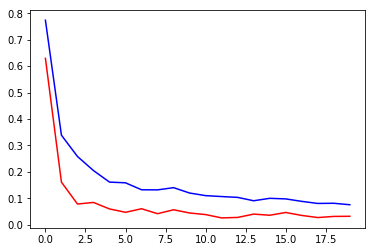

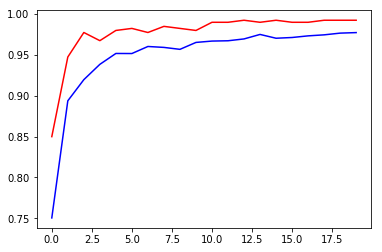

In [17]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [18]:
y_hat = model.predict(x_val)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[421   0   0   0   0   0   3   0   1   0]
 [  0 450   0   0   0   0   0   2   0   0]
 [  0   1 435   1   0   0   0   3   1   1]
 [  0   1   0 410   0   0   0   1   0   3]
 [  0   0   0   0 379   0   0   0   0   2]
 [  0   0   0   2   0 352   1   0   1   0]
 [  0   0   0   0   0   0 434   0   0   0]
 [  0   0   2   0   0   0   0 490   0   0]
 [  0   0   0   0   0   0   1   0 383   3]
 [  0   0   0   0   0   0   0   0   3 413]]


In [19]:
mnist_testset = np.loadtxt(test_file, skiprows=1, dtype='int', delimiter=',')
x_test = mnist_testset.astype("float32")
x_test = x_test.reshape(-1, 28, 28, 1)/255.

In [20]:
y_hat = model.predict(x_test, batch_size=64)
# y_hat consists of class probabilities (corresponding to the one-hot encoding of the training labels). 
# I now select the class with highest probability

In [21]:
y_hat

array([[3.24339839e-12, 1.06881248e-09, 9.99999642e-01, ...,
        1.88015576e-08, 1.44158396e-09, 1.95537156e-10],
       [9.99960542e-01, 7.32093275e-09, 1.76652611e-06, ...,
        2.69301012e-07, 1.49545494e-05, 8.74998113e-06],
       [2.69656897e-09, 1.16175417e-10, 1.02617275e-08, ...,
        7.13075565e-07, 3.59809274e-05, 9.99822080e-01],
       ...,
       [6.31744658e-15, 2.88876145e-10, 1.93735611e-10, ...,
        1.52620097e-10, 3.60140862e-10, 3.19386156e-10],
       [5.81796655e-07, 1.56243338e-08, 3.44065626e-07, ...,
        3.94473936e-05, 1.18835278e-05, 9.99496102e-01],
       [2.44982355e-12, 2.81183216e-10, 9.99999285e-01, ...,
        8.54713367e-09, 6.87929935e-09, 3.99826450e-10]], dtype=float32)

In [22]:
y_pred = np.argmax(y_hat,axis=1)

In [23]:
y_pred

array([2, 0, 9, ..., 3, 9, 2])

In [24]:
with open(submission_file,'w') as f:
    f.write('ImageId, Label\n')
    for i in range(len(y_pred)):
        f.write("".join([str(i+1),',',str(y_pred[i]),'\n']))